In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 5
expName = "NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2"
outPath = "Results"
foldName = "folds.pickle"

epochs = 100
batch_size = 64
shuffle = True
seed = None

input_data_folder = "Data"
training_data_file = "Training-datasets-PredNTS.txt"
independent_data_file = "independent dataset-PredNTS.txt"

In [3]:
import os 
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef, classification_report

import math

import matplotlib.pyplot as plt

In [4]:
# print(tf.test.is_gpu_available(cuda_only=True))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
##################################################################################
##### define all CUSTOM functions
##################################################################################

def one_hot_encode_nt(sequence, char_dict):
    
    seq_encoded = np.zeros((len(sequence),len(char_dict)))
    
    i = 0
    for single_character in sequence:
        if(single_character.upper() in char_dict.keys()):
            seq_encoded[i][char_dict[single_character.upper()]] = 1
            i = i+1
        else:
            raise ValueError('Incorrect character in NT sequence: '+sequence)
    return seq_encoded

In [6]:
##################################################################################
##### Build k-fold functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList



In [7]:
##################################################################################
##### define evaluator functions
##################################################################################

def pred2label(y_pred):
    y_pred = np.round(y_pred)
    return y_pred

def labels_1d_to_2d(labels_1d):
    labels_2d = np.eye(2)[labels_1d]
    return labels_2d

# Model

In [8]:
##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def DLNN_CORENup(input_seq_shape = (41, 21),
                 conv_filters_per_layer_1 = 50, kernel_length_1 = 5, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 2, max_pool_stride_1 = 2, ## 1st Maxpool layer parameters
                 lstm_decode_units = 50, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 50,  kernel_length_2 = 10, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 2, max_pool_stride_2 = 2, ## 2nd Maxpool layer parameters
                 dense_decode_units = 370, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0003, loss = 'binary_crossentropy', metrics = None):
    
    beta = 0.001
    
    ######################################################################################################
    ########  SEQUENCE  ##################################################################################
    ######################################################################################################
    
    input1 = tf.keras.layers.Input(shape=input_seq_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
                                strides = conv_strides_1, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)

    ## Conv Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, 
                                strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)
    
    x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(x4)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
                      loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
                      loss = loss)

    return model

In [9]:
# ##################################################################################
# ##### Function to customize the DLNN architecture with parameters
# ##################################################################################

# def DLNN_CORENup(input_seq_shape = (41, 21),
#                  conv_filters_per_layer_1 = 10, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
#                  max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
#                  lstm_decode_units = 10, ## LSTM layer parameters
#                  conv_filters_per_layer_2 = 10,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
#                  max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
#                  dense_decode_units = 32, ## Dense layer parameters
#                  prob = 0.5, learn_rate = 0.0005, 
#                  loss = 'binary_crossentropy', metrics = None):
    
#     beta = 0.001
    
#     ######################################################################################################
#     ########  SEQUENCE  ##################################################################################
#     ######################################################################################################
    
#     input1 = tf.keras.layers.Input(shape=input_seq_shape)

#     x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
#                                 strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                                 padding = "same")(input1)
#     x1 = tf.keras.layers.Activation('relu')(x1)
#     x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
#     x1 = tf.keras.layers.Dropout(prob)(x1)

#     ## LSTM Path

#     x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    
#     x2 = tf.keras.layers.Dropout(prob)(x2)
    
#     x2 = tf.keras.layers.Flatten()(x2)

#     ## Conv Path

#     x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
#                                 kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
#     x3 = tf.keras.layers.Activation('relu')(x3)
#     x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
#     x3 = tf.keras.layers.Dropout(prob)(x3)
    
#     x3 = tf.keras.layers.Flatten()(x3)
    
#     x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
#     ######################################################################################################
#     ########  Classifier  ################################################################################
#     ######################################################################################################
    
#     y = tf.keras.layers.Dense(dense_decode_units, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'relu')(x4)
    
#     y = tf.keras.layers.Dropout(prob)(y)
    
#     y = tf.keras.layers.Dense(1, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta),
#                               activation = 'sigmoid')(y)

#     ## Generate Model from input and output
#     model = tf.keras.models.Model(inputs=input1, outputs=y)
    
#     ## Compile model
#     if(metrics != None):
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
#     else:
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

#     return model

In [10]:
DLNN_CORENup().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 41, 21)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 41, 50)       5300        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 41, 50)       0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 20, 50)       0           ['activation[0][0]']             
                                                                                              

# Read Data

In [11]:
##################################################################################
##### read training file
##################################################################################
train_file_path = os.path.join(input_data_folder, training_data_file)
train_data = pd.read_csv(train_file_path, sep='\t', header=None)
train_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']

# Independent Dataset

In [12]:
##################################################################################
##### read independent data file
##################################################################################
indpe_file_path = os.path.join(input_data_folder, independent_data_file)
indpe_data = pd.read_csv(indpe_file_path, sep='\t', header=None)
indpe_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']

# Exploratory Data Analysis

In [13]:
def print_and_get_stats(source_data, target_data):
    
    # empty char count per sequence
    source_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in source_data['Sequence']]
    # incomplete sequence flag
    source_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in source_data['Sequence']]
    
    target_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in target_data['Sequence']]
    target_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in target_data['Sequence']]

    # 0:1
    train_label_nonempty_ratio = source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    train_label_ratio = (source_data.shape[0]-sum(source_data["label_original"] == 1)) / sum(source_data["label_original"] == 1)

    # 0:1
    indpe_label_nonempty_ratio = target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    indpe_label_ratio = (target_data.shape[0]-sum(target_data["label_original"] == 1)) / sum(target_data["label_original"] == 1)

    print('Current train_label_nonempty_ratio:', train_label_nonempty_ratio, 'train_label_ratio:', train_label_ratio)
    print('Target indpe_label_nonempty_ratio:', indpe_label_nonempty_ratio, 'indpe_label_ratio:', indpe_label_ratio)

    increase_0_data_factor = int(round(indpe_label_ratio/train_label_ratio)) - 1
    increase_empty_data_factor = int(round(indpe_label_nonempty_ratio/train_label_nonempty_ratio)) - 1
    
    return increase_0_data_factor, increase_empty_data_factor

In [14]:
# empty char count per sequence
train_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in train_data['Sequence']]
# incomplete sequence flag
train_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in train_data['Sequence']]

indpe_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in indpe_data['Sequence']]
indpe_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in indpe_data['Sequence']]

### Train

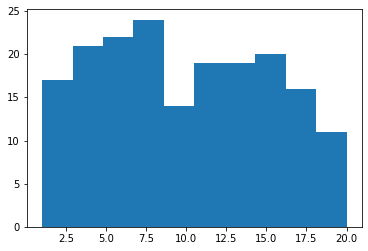

Total empty records: 183
Ratio empty/total: 0.07682619647355164


In [15]:
plt.hist(train_data['Empty_count'][train_data['Empty_count'] != 0])
plt.show()
print('Total empty records:', sum(train_data['has_empty']))
print('Ratio empty/total:', sum(train_data['has_empty'])/train_data.shape[0])

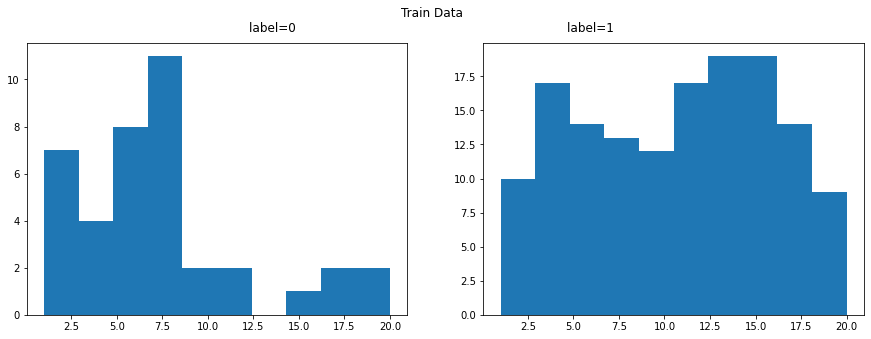

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Data\nlabel=0                                                                      label=1')
axs[0].hist(train_data['Empty_count'][(train_data['Empty_count'] != 0) & (train_data['label_original'] == -1)])
axs[1].hist(train_data['Empty_count'][(train_data['Empty_count'] != 0) & (train_data['label_original'] == 1)])
plt.show()

In [17]:
train_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()

,label_original,has_empty
0,-1,39
1,1,144


### independent

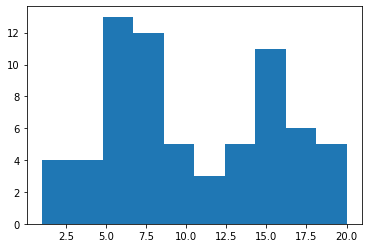

Total empty records: 68
Ratio empty/total: 0.05551020408163265


In [18]:
plt.hist(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0])
plt.show()
print('Total empty records:', sum(indpe_data['has_empty']))
print('Ratio empty/total:', sum(indpe_data['has_empty'])/indpe_data.shape[0])

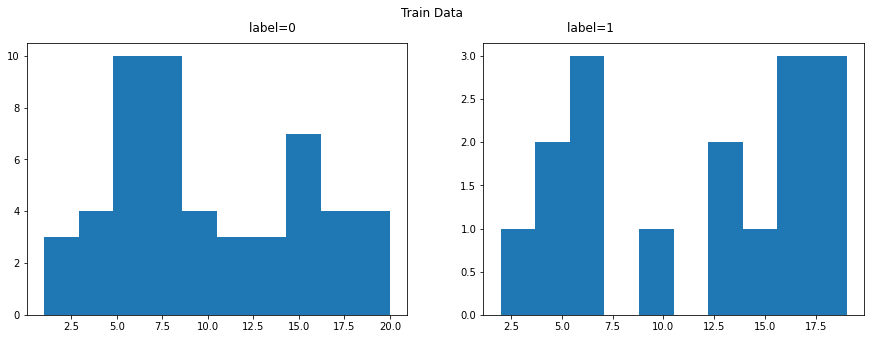

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Data\nlabel=0                                                                      label=1')
axs[0].hist(indpe_data['Empty_count'][(indpe_data['Empty_count'] != 0) & (indpe_data['label_original'] == -1)])
axs[1].hist(indpe_data['Empty_count'][(indpe_data['Empty_count'] != 0) & (indpe_data['label_original'] == 1)])
plt.show()

In [20]:
indpe_data.groupby(["label_original"]).sum().filter(['has_empty'])

,has_empty
label_original,
-1,52
1,16


In [21]:
_,_ = print_and_get_stats(train_data, indpe_data)

Current train_label_nonempty_ratio: 0.2708333333333333 train_label_ratio: 1.0
Target indpe_label_nonempty_ratio: 3.25 indpe_label_ratio: 5.0344827586206895


# Data Augmentation on Training dataset

In [22]:
import random

def sequence_truncate(seq, random_length):
    rep_str = "".join(['-']*random_length)
    if np.random.choice((True, False)):
        return_seq = rep_str + seq[random_length:]
    else:
        return_seq = seq[:-random_length] + rep_str
    return return_seq

def random_sequence_truncate(seq):
    random_length = np.random.randint(1, 20)
    return_seq = sequence_truncate(seq, random_length)
    return return_seq

def repeat_truncate_sequence_steps(seq, factor):
    random_length = random.sample(range(1, int(len(seq)/2)), 
                                  factor)
    return_seqs = []
    for i in range(factor):
        ret_seq = sequence_truncate(seq, random_length[i])
        return_seqs.append(ret_seq)
    return return_seqs

def truncate_sequence_by_len(seq, ran_len):
    return_seqs = []
    ret_seq = sequence_truncate(seq, ran_len)
    return ret_seq

In [23]:
def print_and_get_stats(source_data, target_data):
    
    # empty char count per sequence
    source_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in source_data['Sequence']]
    # incomplete sequence flag
    source_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in source_data['Sequence']]
    
    target_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in target_data['Sequence']]
    target_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in target_data['Sequence']]

    # 0:1
    train_label_nonempty_ratio = source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    train_label_ratio = (source_data.shape[0]-sum(source_data["label_original"] == 1)) / sum(source_data["label_original"] == 1)

    # 0:1
    indpe_label_nonempty_ratio = target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    indpe_label_ratio = (target_data.shape[0]-sum(target_data["label_original"] == 1)) / sum(target_data["label_original"] == 1)

    print('Current train_label_nonempty_ratio:', train_label_nonempty_ratio, 'train_label_ratio:', train_label_ratio)
    print('Target indpe_label_nonempty_ratio:', indpe_label_nonempty_ratio, 'indpe_label_ratio:', indpe_label_ratio)

    increase_0_data_factor = int(round(indpe_label_ratio/train_label_ratio)) - 1
    increase_empty_data_factor = int(round(indpe_label_nonempty_ratio/train_label_nonempty_ratio)) - 1
    
    return increase_0_data_factor, increase_empty_data_factor

In [24]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

hist, bins = np.histogram(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0], bins=10)

bin_midpoints = bins[:-1] + np.diff(bins)/2
cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]
values = np.random.rand(100)
value_bins = np.searchsorted(cdf, values)
random_from_cdf = bin_midpoints[value_bins]

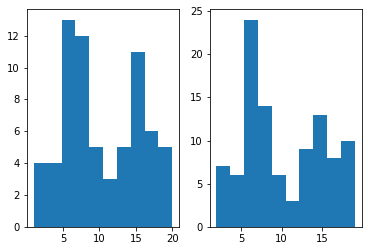

In [25]:
plt.subplot(121)
plt.hist(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0], 10)
plt.subplot(122)
plt.hist(np.round(random_from_cdf).astype(int), 10)
plt.show()

In [26]:
# empty char count per sequence
train_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in train_data['Sequence']]
# incomplete sequence flag
train_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in train_data['Sequence']]

# before balancing

# train_data = train_data_backup

########

factor = 1

data = train_data
neg_data = data[data['label_original'] == -1].reset_index(drop=True)
pos_data = data[data['label_original'] == 1].reset_index(drop=True)
# neg_data = data.reset_index(drop=True)

not_empty_neg_idxs = np.where(neg_data['has_empty'] != True)[0]
not_empty_neg_idxs = np.random.permutation(not_empty_neg_idxs)
not_empty_pos_idxs = np.where(pos_data['has_empty'] != True)[0]
not_empty_pos_idxs = np.random.permutation(not_empty_pos_idxs)[0:int(not_empty_neg_idxs.shape[0]/factor)]

##### Getting missing distribution
hist, bins = np.histogram(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0], bins=20)
bin_midpoints = bins[:-1] + np.diff(bins)/2
cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]

##### Negative records augmentation
neg_values = np.random.rand(not_empty_neg_idxs.shape[0])
neg_value_bins = np.searchsorted(cdf, neg_values)
neg_random_from_cdf = bin_midpoints[neg_value_bins]
neg_random_from_cdf = np.round(neg_random_from_cdf).astype(int)

for idx, ran_len in zip(list(not_empty_neg_idxs), list(list(neg_random_from_cdf))):
    record = neg_data.iloc[idx].to_dict()
    seq = truncate_sequence_by_len(record['Sequence'], ran_len)
    record['Sequence'] = seq
    neg_data = neg_data.append(record, ignore_index=True)

##### Positive records augmentation
pos_values = np.random.rand(not_empty_pos_idxs.shape[0])
pos_value_bins = np.searchsorted(cdf, pos_values)
pos_random_from_cdf = bin_midpoints[pos_value_bins]
pos_random_from_cdf = np.round(pos_random_from_cdf).astype(int)
    
for idx, ran_len in zip(list(not_empty_pos_idxs), list(list(pos_random_from_cdf))):
    record = pos_data.iloc[idx].to_dict()
    seq = truncate_sequence_by_len(record['Sequence'], ran_len)
    record['Sequence'] = seq
    pos_data = pos_data.append(record, ignore_index=True)
    
#     seqs = repeat_truncate_sequence_steps(record['Sequence'], factor)
#     for seq in seqs:
#         record['Sequence'] = seq
#         neg_data = neg_data.append(record, ignore_index=True)

final_data = pd.concat((neg_data, pos_data, data))
print(final_data.shape)

##########################

_ , _ = print_and_get_stats(final_data, indpe_data)

##########################

final_data = final_data.drop_duplicates().reset_index(drop=True)
print(final_data.shape)

print('\n##### After removing duplicates #####\n')
##########

_ , _ = print_and_get_stats(final_data, indpe_data)

(6963, 8)
Current train_label_nonempty_ratio: 0.9213483146067416 train_label_ratio: 1.0306211723534557
Target indpe_label_nonempty_ratio: 3.25 indpe_label_ratio: 5.0344827586206895
(4581, 8)

##### After removing duplicates #####

Current train_label_nonempty_ratio: 1.0 train_label_ratio: 1.0469168900804289
Target indpe_label_nonempty_ratio: 3.25 indpe_label_ratio: 5.0344827586206895


In [27]:
train_data = final_data

# empty char count per sequence
train_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in train_data['Sequence']]
# incomplete sequence flag
train_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in train_data['Sequence']]

# before balancing

# train_data = train_data_backup

########

factor = 1

data = train_data
neg_data = data[data['label_original'] == -1].reset_index(drop=True)
pos_data = data[data['label_original'] == 1].reset_index(drop=True)
# neg_data = data.reset_index(drop=True)

not_empty_neg_idxs = np.where(neg_data['has_empty'] != True)[0]
not_empty_neg_idxs = np.random.permutation(not_empty_neg_idxs)
not_empty_pos_idxs = np.where(pos_data['has_empty'] != True)[0]
not_empty_pos_idxs = np.random.permutation(not_empty_pos_idxs)[0:int(not_empty_neg_idxs.shape[0]/factor)]

##### Getting missing distribution
hist, bins = np.histogram(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0], bins=20)
bin_midpoints = bins[:-1] + np.diff(bins)/2
cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]

##### Negative records augmentation
neg_values = np.random.rand(not_empty_neg_idxs.shape[0])
neg_value_bins = np.searchsorted(cdf, neg_values)
neg_random_from_cdf = bin_midpoints[neg_value_bins]
neg_random_from_cdf = np.round(neg_random_from_cdf).astype(int)

for idx, ran_len in zip(list(not_empty_neg_idxs), list(list(neg_random_from_cdf))):
    record = neg_data.iloc[idx].to_dict()
    seq = truncate_sequence_by_len(record['Sequence'], ran_len)
    record['Sequence'] = seq
    neg_data = neg_data.append(record, ignore_index=True)

##### Positive records augmentation
pos_values = np.random.rand(not_empty_pos_idxs.shape[0])
pos_value_bins = np.searchsorted(cdf, pos_values)
pos_random_from_cdf = bin_midpoints[pos_value_bins]
pos_random_from_cdf = np.round(pos_random_from_cdf).astype(int)
    
for idx, ran_len in zip(list(not_empty_pos_idxs), list(list(pos_random_from_cdf))):
    record = pos_data.iloc[idx].to_dict()
    seq = truncate_sequence_by_len(record['Sequence'], ran_len)
    record['Sequence'] = seq
    pos_data = pos_data.append(record, ignore_index=True)
    
#     seqs = repeat_truncate_sequence_steps(record['Sequence'], factor)
#     for seq in seqs:
#         record['Sequence'] = seq
#         neg_data = neg_data.append(record, ignore_index=True)

final_data = pd.concat((neg_data, pos_data, data))
print(final_data.shape)

##########################

_ , _ = print_and_get_stats(final_data, indpe_data)

##########################

final_data = final_data.drop_duplicates().reset_index(drop=True)
print(final_data.shape)

print('\n##### After removing duplicates #####\n')
##########

_ , _ = print_and_get_stats(final_data, indpe_data)

(11361, 8)
Current train_label_nonempty_ratio: 1.0306211723534557 train_label_ratio: 1.0570342205323193
Target indpe_label_nonempty_ratio: 3.25 indpe_label_ratio: 5.0344827586206895
(6706, 8)

##### After removing duplicates #####

Current train_label_nonempty_ratio: 1.049567985447931 train_label_ratio: 1.0659272951324708
Target indpe_label_nonempty_ratio: 3.25 indpe_label_ratio: 5.0344827586206895


In [28]:
# # after balancing

# # train_data = train_data_backup

# ########

# factor = 3

# data = train_data
# neg_data = data[data['label_original'] == -1].reset_index(drop=True)
# pos_data = data[data['label_original'] == 1].reset_index(drop=True)
# # neg_data = data.reset_index(drop=True)

# not_empty_neg_idxs = np.where(neg_data['has_empty'] != True)[0]
# not_empty_pos_idxs = np.where(pos_data['has_empty'] != True)[0]
# not_empty_pos_idxs = np.random.permutation(not_empty_pos_idxs)[0:int(not_empty_neg_idxs.shape[0]/factor)]
# not_empty_neg_idxs = np.random.permutation(not_empty_neg_idxs)[0:int(not_empty_pos_idxs.shape[0]/factor)]


# ##### Getting missing distribution
# hist, bins = np.histogram(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0], bins=20)
# bin_midpoints = bins[:-1] + np.diff(bins)/2
# cdf = np.cumsum(hist)
# cdf = cdf / cdf[-1]

# ##### Negative records augmentation
# neg_values = np.random.rand(not_empty_neg_idxs.shape[0])
# neg_value_bins = np.searchsorted(cdf, neg_values)
# neg_random_from_cdf = bin_midpoints[neg_value_bins]
# neg_random_from_cdf = np.round(neg_random_from_cdf).astype(int)

# for idx, ran_len in zip(list(not_empty_neg_idxs), list(list(neg_random_from_cdf))):
#     record = neg_data.iloc[idx].to_dict()
#     seq = truncate_sequence_by_len(record['Sequence'], ran_len)
#     record['Sequence'] = seq
#     neg_data = neg_data.append(record, ignore_index=True)

# ##### Positive records augmentation
# pos_values = np.random.rand(not_empty_pos_idxs.shape[0])
# pos_value_bins = np.searchsorted(cdf, pos_values)
# pos_random_from_cdf = bin_midpoints[pos_value_bins]
# pos_random_from_cdf = np.round(pos_random_from_cdf).astype(int)
    
# for idx, ran_len in zip(list(not_empty_pos_idxs), list(list(pos_random_from_cdf))):
#     record = pos_data.iloc[idx].to_dict()
#     seq = truncate_sequence_by_len(record['Sequence'], ran_len)
#     record['Sequence'] = seq
#     pos_data = pos_data.append(record, ignore_index=True)
    
# #     seqs = repeat_truncate_sequence_steps(record['Sequence'], factor)
# #     for seq in seqs:
# #         record['Sequence'] = seq
# #         neg_data = neg_data.append(record, ignore_index=True)

# final_data = pd.concat((neg_data, pos_data, data))
# print(final_data.shape)

# ##########################

# _ , _ = print_and_get_stats(final_data, indpe_data)

# ##########################

# final_data = final_data.drop_duplicates().reset_index(drop=True)
# print(final_data.shape)

# print('\n##### After removing duplicates #####\n')
# ##########

# _ , _ = print_and_get_stats(final_data, indpe_data)

In [29]:
# empty char count per sequence
final_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in final_data['Sequence']]
# incomplete sequence flag
final_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in final_data['Sequence']]

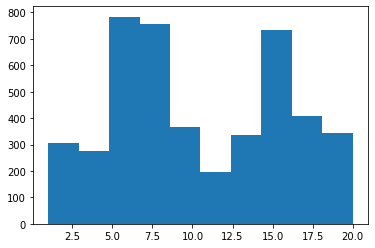

Total empty records: 4507
Ratio empty/total: 0.6720847002684164


In [30]:
plt.hist(final_data['Empty_count'][final_data['Empty_count'] != 0])
plt.show()
print('Total empty records:', sum(final_data['has_empty']))
print('Ratio empty/total:', sum(final_data['has_empty'])/final_data.shape[0])

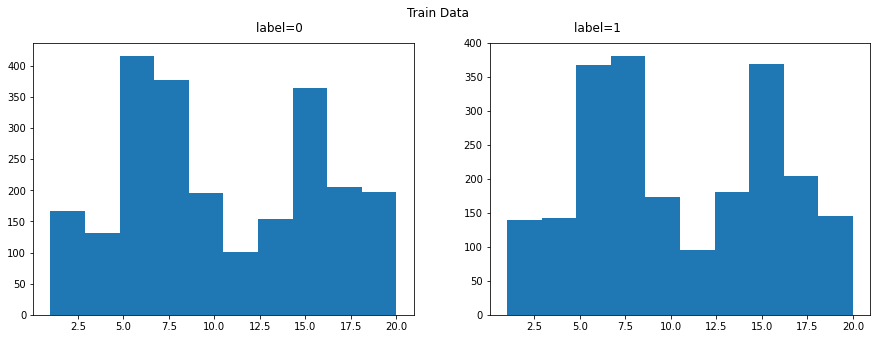

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Data\nlabel=0                                                                      label=1')
axs[0].hist(final_data['Empty_count'][(final_data['Empty_count'] != 0) & (final_data['label_original'] == -1)])
axs[1].hist(final_data['Empty_count'][(final_data['Empty_count'] != 0) & (final_data['label_original'] == 1)])
plt.show()

In [32]:
final_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()

,label_original,has_empty
0,-1,2308
1,1,2199


##  Final preparations for training data

In [33]:
train_data = final_data

##################################################################################
##### Create dictionary of all characters in the NT sequence 
##################################################################################
all_char_set = set({})
for val in [set(val) for val in train_data['Sequence']]:
    all_char_set = all_char_set.union(val)
all_char_list = list(all_char_set)
all_char_list.sort()
all_char_dict = {}
for i in range(len(all_char_list)):
    all_char_dict[all_char_list[i]] = i
    
##################################################################################
##### Create OHE of sequence
##################################################################################
train_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in train_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
train_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in train_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

train_features = np.array(list(train_data['OHE_Sequence']))
train_labels = np.array(list(train_data['label']))
train_labels = train_labels.reshape((train_labels.shape[0], 1))

input_seq_shape = train_features[0].shape

folds = build_kfold(train_features, train_labels, k=n_fold, shuffle=shuffle, seed=seed)

## Write the k-fold dataset to file
foldPath = os.path.join(outPath, expName, "{}fold".format(n_fold))
if(not os.path.isdir(foldPath)):
    os.makedirs(foldPath)
pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

# Final prep for Independent dataset

In [34]:
##################################################################################
##### Create OHE of sequence
##################################################################################
indpe_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in indpe_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
indpe_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in indpe_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

indpe_features = np.array(list(indpe_data['OHE_Sequence']))
indpe_labels = np.array(list(indpe_data['label']))
indpe_labels = indpe_labels.reshape((indpe_labels.shape[0], 1))

input_seq_shape = indpe_features[0].shape

In [35]:
input_seq_shape

(41, 21)

# Training

In [36]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Train/Test model on all folds, generate evaluations
##################################################################################

## Create and set directory to save model
modelPath = os.path.join(outPath, expName, "{}fold".format(n_fold), "models")
if(not os.path.isdir(modelPath)):
    os.makedirs(modelPath)

i = -1
for fold in folds:
    i += 1
    
    print("\nTrain/Test model on Fold #"+str(i)+".")
    
    model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
    ## Define the model callbacks for early stopping and saving the model. Then train model
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                           monitor = 'val_loss', verbose = 1, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
    ]
    
    # adding random shuffling of the dataset for training purpose
    index_arr = np.arange(fold["X_train"].shape[0])
    index_arr = np.random.permutation(index_arr)
    
    model.fit(x = fold["X_train"][index_arr], y = fold["y_train"][index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
              callbacks = modelCallbacks, validation_data = (fold["X_test"], fold["y_test"]))
    
    model = tf.keras.models.load_model(current_model_path)
    
    ##################################################################################
    ##### Prediction and metrics for TRAIN dataset
    ##################################################################################

    y_pred = model.predict(fold["X_train"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_train"], label_pred)
    prec = precision_score(fold["y_train"],label_pred)
    mcc = matthews_corrcoef(fold["y_train"], label_pred)

    conf = confusion_matrix(fold["y_train"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
    auc = roc_auc_score(fold["y_train"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Train")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    ##################################################################################
    ##### Prediction and metrics for TEST dataset
    ##################################################################################

    y_pred = model.predict(fold["X_test"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_test"], label_pred)
    prec = precision_score(fold["y_test"],label_pred)
    mcc = matthews_corrcoef(fold["y_test"], label_pred)

    conf = confusion_matrix(fold["y_test"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
    auc = roc_auc_score(fold["y_test"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Test")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)


Train/Test model on Fold #0.
Epoch 1/100
84/84 [==============================] - ETA: 0s - loss: 1.3380
Epoch 1: val_loss improved from inf to 1.22081, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold0.hdf5
84/84 [==============================] - 6s 15ms/step - loss: 1.3380 - val_loss: 1.2208
Epoch 2/100
80/84 [===========================>..] - ETA: 0s - loss: 1.1354
Epoch 2: val_loss improved from 1.22081 to 0.99049, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold0.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 1.1300 - val_loss: 0.9905
Epoch 3/100
81/84 [===========================>..] - ETA: 0s - loss: 0.9759
Epoch 3: val_loss improved from 0.99049 to 0.88487, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold0.hdf5
84/84 [==============================] - 1s 10ms/step - loss

84/84 [==============================] - 1s 9ms/step - loss: 0.4653 - val_loss: 0.4517
Epoch 27/100
78/84 [==========================>...] - ETA: 0s - loss: 0.4542
Epoch 27: val_loss improved from 0.45173 to 0.44660, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold0.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.4551 - val_loss: 0.4466
Epoch 28/100
81/84 [===========================>..] - ETA: 0s - loss: 0.4496
Epoch 28: val_loss improved from 0.44660 to 0.44229, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold0.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.4509 - val_loss: 0.4423
Epoch 29/100
78/84 [==========================>...] - ETA: 0s - loss: 0.4485
Epoch 29: val_loss did not improve from 0.44229
84/84 [==============================] - 1s 9ms/step - loss: 0.4503 - val_loss: 0.4468
Epoch 30/100
79/84 [===========

78/84 [==========================>...] - ETA: 0s - loss: 0.3490
Epoch 54: val_loss did not improve from 0.34073
84/84 [==============================] - 1s 9ms/step - loss: 0.3496 - val_loss: 0.3469
Epoch 55/100
84/84 [==============================] - ETA: 0s - loss: 0.3532
Epoch 55: val_loss improved from 0.34073 to 0.33872, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold0.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.3532 - val_loss: 0.3387
Epoch 56/100
82/84 [============================>.] - ETA: 0s - loss: 0.3436
Epoch 56: val_loss improved from 0.33872 to 0.33852, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold0.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.3438 - val_loss: 0.3385
Epoch 57/100
84/84 [==============================] - ETA: 0s - loss: 0.3250
Epoch 57: val_loss did not improve from 0.33852
84/84

Epoch 84/100
80/84 [===========================>..] - ETA: 0s - loss: 0.3080
Epoch 84: val_loss improved from 0.30016 to 0.29775, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold0.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.3071 - val_loss: 0.2978
Epoch 85/100
80/84 [===========================>..] - ETA: 0s - loss: 0.3070
Epoch 85: val_loss did not improve from 0.29775
84/84 [==============================] - 1s 9ms/step - loss: 0.3056 - val_loss: 0.3049
Epoch 86/100
79/84 [===========================>..] - ETA: 0s - loss: 0.3079
Epoch 86: val_loss improved from 0.29775 to 0.29579, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold0.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.3083 - val_loss: 0.2958
Epoch 87/100
78/84 [==========================>...] - ETA: 0s - loss: 0.3047
Epoch 87: val_loss did not improve from 0

84/84 [==============================] - 1s 9ms/step - loss: 0.6222 - val_loss: 0.6250
Epoch 13/100
81/84 [===========================>..] - ETA: 0s - loss: 0.6053
Epoch 13: val_loss improved from 0.62500 to 0.60655, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold1.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.6057 - val_loss: 0.6066
Epoch 14/100
84/84 [==============================] - ETA: 0s - loss: 0.5901
Epoch 14: val_loss improved from 0.60655 to 0.60239, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold1.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.5901 - val_loss: 0.6024
Epoch 15/100
78/84 [==========================>...] - ETA: 0s - loss: 0.5805
Epoch 15: val_loss improved from 0.60239 to 0.58870, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold1.

84/84 [==============================] - 1s 9ms/step - loss: 0.3901 - val_loss: 0.4062
Epoch 39/100
82/84 [============================>.] - ETA: 0s - loss: 0.3861
Epoch 39: val_loss did not improve from 0.40622
84/84 [==============================] - 1s 8ms/step - loss: 0.3863 - val_loss: 0.4216
Epoch 40/100
80/84 [===========================>..] - ETA: 0s - loss: 0.3872
Epoch 40: val_loss improved from 0.40622 to 0.40183, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold1.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.3875 - val_loss: 0.4018
Epoch 41/100
81/84 [===========================>..] - ETA: 0s - loss: 0.3743
Epoch 41: val_loss improved from 0.40183 to 0.39926, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold1.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.3758 - val_loss: 0.3993
Epoch 42/100
79/84 [===========

79/84 [===========================>..] - ETA: 0s - loss: 0.3259
Epoch 66: val_loss did not improve from 0.33662
84/84 [==============================] - 1s 8ms/step - loss: 0.3250 - val_loss: 0.3387
Epoch 67/100
78/84 [==========================>...] - ETA: 0s - loss: 0.3213
Epoch 67: val_loss did not improve from 0.33662
84/84 [==============================] - 1s 8ms/step - loss: 0.3244 - val_loss: 0.3395
Epoch 68/100
78/84 [==========================>...] - ETA: 0s - loss: 0.3131
Epoch 68: val_loss did not improve from 0.33662
84/84 [==============================] - 1s 9ms/step - loss: 0.3133 - val_loss: 0.3377
Epoch 69/100
78/84 [==========================>...] - ETA: 0s - loss: 0.3046
Epoch 69: val_loss improved from 0.33662 to 0.32728, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold1.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.3067 - val_loss: 0.3273
Epoch 70/100
78/84 [======================

Epoch 96/100
79/84 [===========================>..] - ETA: 0s - loss: 0.2960
Epoch 96: val_loss did not improve from 0.29331
84/84 [==============================] - 1s 10ms/step - loss: 0.2932 - val_loss: 0.2961
Epoch 97/100
78/84 [==========================>...] - ETA: 0s - loss: 0.2851
Epoch 97: val_loss did not improve from 0.29331
84/84 [==============================] - 1s 9ms/step - loss: 0.2883 - val_loss: 0.2952
Epoch 98/100
81/84 [===========================>..] - ETA: 0s - loss: 0.2841
Epoch 98: val_loss improved from 0.29331 to 0.29177, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold1.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.2827 - val_loss: 0.2918
Epoch 99/100
80/84 [===========================>..] - ETA: 0s - loss: 0.2767
Epoch 99: val_loss improved from 0.29177 to 0.29087, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fo

Epoch 22/100
80/84 [===========================>..] - ETA: 0s - loss: 0.5077
Epoch 22: val_loss improved from 0.54497 to 0.53758, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold2.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.5099 - val_loss: 0.5376
Epoch 23/100
78/84 [==========================>...] - ETA: 0s - loss: 0.4937
Epoch 23: val_loss did not improve from 0.53758
84/84 [==============================] - 1s 8ms/step - loss: 0.4927 - val_loss: 0.5379
Epoch 24/100
83/84 [============================>.] - ETA: 0s - loss: 0.4925
Epoch 24: val_loss improved from 0.53758 to 0.51990, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold2.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.4928 - val_loss: 0.5199
Epoch 25/100
84/84 [==============================] - ETA: 0s - loss: 0.4785
Epoch 25: val_loss improved from 0.51990

84/84 [==============================] - 1s 9ms/step - loss: 0.3700 - val_loss: 0.4249
Epoch 49/100
78/84 [==========================>...] - ETA: 0s - loss: 0.3680
Epoch 49: val_loss improved from 0.41935 to 0.41625, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold2.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.3700 - val_loss: 0.4163
Epoch 50/100
78/84 [==========================>...] - ETA: 0s - loss: 0.3575
Epoch 50: val_loss improved from 0.41625 to 0.40555, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold2.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.3588 - val_loss: 0.4056
Epoch 51/100
78/84 [==========================>...] - ETA: 0s - loss: 0.3492
Epoch 51: val_loss did not improve from 0.40555
84/84 [==============================] - 1s 9ms/step - loss: 0.3522 - val_loss: 0.4333
Epoch 52/100
84/84 [===========

82/84 [============================>.] - ETA: 0s - loss: 0.3120
Epoch 77: val_loss improved from 0.35241 to 0.35114, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold2.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.3102 - val_loss: 0.3511
Epoch 78/100
82/84 [============================>.] - ETA: 0s - loss: 0.3204
Epoch 78: val_loss did not improve from 0.35114
84/84 [==============================] - 1s 10ms/step - loss: 0.3202 - val_loss: 0.3535
Epoch 79/100
80/84 [===========================>..] - ETA: 0s - loss: 0.3145
Epoch 79: val_loss improved from 0.35114 to 0.34668, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold2.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.3142 - val_loss: 0.3467
Epoch 80/100
84/84 [==============================] - ETA: 0s - loss: 0.3073
Epoch 80: val_loss did not improve from 0.34668
84/

84/84 [==============================] - ETA: 0s - loss: 0.7805
Epoch 6: val_loss improved from 0.80041 to 0.76008, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold3.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.7805 - val_loss: 0.7601
Epoch 7/100
83/84 [============================>.] - ETA: 0s - loss: 0.7474
Epoch 7: val_loss improved from 0.76008 to 0.73911, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold3.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.7473 - val_loss: 0.7391
Epoch 8/100
79/84 [===========================>..] - ETA: 0s - loss: 0.7220
Epoch 8: val_loss improved from 0.73911 to 0.70152, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold3.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.7216 - val_loss: 0.7015
Epoch 9/10

80/84 [===========================>..] - ETA: 0s - loss: 0.4180
Epoch 31: val_loss improved from 0.45142 to 0.43505, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold3.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.4223 - val_loss: 0.4350
Epoch 32/100
84/84 [==============================] - ETA: 0s - loss: 0.4288
Epoch 32: val_loss improved from 0.43505 to 0.43417, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold3.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.4288 - val_loss: 0.4342
Epoch 33/100
84/84 [==============================] - ETA: 0s - loss: 0.4253
Epoch 33: val_loss improved from 0.43417 to 0.42379, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold3.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.4253 - val_loss: 0.4238
Epoch

Epoch 59/100
79/84 [===========================>..] - ETA: 0s - loss: 0.3388
Epoch 59: val_loss did not improve from 0.34245
84/84 [==============================] - 1s 8ms/step - loss: 0.3394 - val_loss: 0.3436
Epoch 60/100
78/84 [==========================>...] - ETA: 0s - loss: 0.3366
Epoch 60: val_loss did not improve from 0.34245
84/84 [==============================] - 1s 9ms/step - loss: 0.3367 - val_loss: 0.3476
Epoch 61/100
78/84 [==========================>...] - ETA: 0s - loss: 0.3250
Epoch 61: val_loss did not improve from 0.34245
84/84 [==============================] - 1s 9ms/step - loss: 0.3276 - val_loss: 0.3434
Epoch 62/100
79/84 [===========================>..] - ETA: 0s - loss: 0.3322
Epoch 62: val_loss improved from 0.34245 to 0.33679, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold3.hdf5
84/84 [==============================] - 1s 9ms/step - loss: 0.3312 - val_loss: 0.3368
Epoch 63/100
78/84 [=========

84/84 [==============================] - 1s 10ms/step - loss: 0.3016 - val_loss: 0.3056
Epoch 91/100
83/84 [============================>.] - ETA: 0s - loss: 0.2813
Epoch 91: val_loss improved from 0.30564 to 0.30413, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold3.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.2809 - val_loss: 0.3041
Epoch 92/100
82/84 [============================>.] - ETA: 0s - loss: 0.2981
Epoch 92: val_loss improved from 0.30413 to 0.30240, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold3.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.2992 - val_loss: 0.3024
Epoch 93/100
82/84 [============================>.] - ETA: 0s - loss: 0.2891
Epoch 93: val_loss did not improve from 0.30240
84/84 [==============================] - 1s 9ms/step - loss: 0.2886 - val_loss: 0.3141
Epoch 94/100
80/84 [========

84/84 [==============================] - 1s 10ms/step - loss: 0.5561 - val_loss: 0.5374
Epoch 18/100
79/84 [===========================>..] - ETA: 0s - loss: 0.5428
Epoch 18: val_loss improved from 0.53737 to 0.53570, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold4.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.5429 - val_loss: 0.5357
Epoch 19/100
82/84 [============================>.] - ETA: 0s - loss: 0.5340
Epoch 19: val_loss improved from 0.53570 to 0.52877, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold4.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.5340 - val_loss: 0.5288
Epoch 20/100
81/84 [===========================>..] - ETA: 0s - loss: 0.5221
Epoch 20: val_loss improved from 0.52877 to 0.51119, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fol

Epoch 43/100
84/84 [==============================] - ETA: 0s - loss: 0.3772
Epoch 43: val_loss improved from 0.38385 to 0.38035, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold4.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.3772 - val_loss: 0.3803
Epoch 44/100
84/84 [==============================] - ETA: 0s - loss: 0.3785
Epoch 44: val_loss did not improve from 0.38035
84/84 [==============================] - 1s 9ms/step - loss: 0.3785 - val_loss: 0.3812
Epoch 45/100
83/84 [============================>.] - ETA: 0s - loss: 0.3814
Epoch 45: val_loss improved from 0.38035 to 0.37972, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold4.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.3813 - val_loss: 0.3797
Epoch 46/100
82/84 [============================>.] - ETA: 0s - loss: 0.3768
Epoch 46: val_loss improved from 0.3797

79/84 [===========================>..] - ETA: 0s - loss: 0.3274
Epoch 71: val_loss did not improve from 0.32681
84/84 [==============================] - 1s 9ms/step - loss: 0.3306 - val_loss: 0.3283
Epoch 72/100
83/84 [============================>.] - ETA: 0s - loss: 0.3108
Epoch 72: val_loss improved from 0.32681 to 0.32327, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold4.hdf5
84/84 [==============================] - 1s 10ms/step - loss: 0.3108 - val_loss: 0.3233
Epoch 73/100
82/84 [============================>.] - ETA: 0s - loss: 0.3158
Epoch 73: val_loss did not improve from 0.32327
84/84 [==============================] - 1s 9ms/step - loss: 0.3167 - val_loss: 0.3266
Epoch 74/100
83/84 [============================>.] - ETA: 0s - loss: 0.3113
Epoch 74: val_loss improved from 0.32327 to 0.32146, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\bestModel-fold4.hdf5
84/84

## k-fold Training evaluation

In [37]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.926930,0.924226,0.976035,0.924830,0.928902,0.853762
Train,0.991314,0.991903,0.999392,0.990142,0.992413,0.982615


In [38]:
evaluations_df[evaluations_df["Train_Test"] == "Test"]

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
1,0,Test,0.933681,0.934884,"[0.0, 0.0015384615384615385, 0.26, 0.26, 0.34,...","[0.0, 0.0, 0.0, 0.001445086705202312, 0.001445...","[1.999573, 0.99957305, 0.98379797, 0.98372287,...",0.979201,0.927692,0.939306,0.867225
3,1,Test,0.934377,0.928244,"[0.0, 0.0015408320493066256, 0.146379044684129...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.001445086705202312...","[1.999999, 0.99999905, 0.99426866, 0.9941268, ...",0.977853,0.936826,0.932081,0.868692
5,2,Test,0.906040,0.909233,"[0.0, 0.0015408320493066256, 0.505392912172573...","[0.0, 0.0, 0.0, 0.001445086705202312, 0.001445...","[1.9999429, 0.9999429, 0.9266747, 0.92638284, ...",0.971991,0.895223,0.916185,0.811888
7,3,Test,0.928412,0.926040,"[0.0, 0.0015408320493066256, 0.351309707241910...","[0.0, 0.0, 0.0, 0.001445086705202312, 0.001445...","[1.99997, 0.99996996, 0.9733287, 0.9729856, 0....",0.975264,0.926040,0.930636,0.856676
9,4,Test,0.932140,0.922727,"[0.0, 0.0015408320493066256, 0.100154083204930...","[0.0, 0.0, 0.0, 0.001445086705202312, 0.001445...","[1.9998537, 0.99985373, 0.9920839, 0.9919121, ...",0.975868,0.938367,0.926301,0.864329


# Independent data testing

## Using k-fold Models

### Performance of each k-fold model

In [39]:
## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    label_pred = pred2label(y_pred)

    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(indpe_labels, label_pred)
    prec = precision_score(indpe_labels,label_pred)
    mcc = matthews_corrcoef(indpe_labels, label_pred)

    conf = confusion_matrix(indpe_labels, label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
    auc = roc_auc_score(indpe_labels, y_pred)

    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Independent")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.650612,0.257916,0.666421,0.589163,0.662818,0.193297


In [40]:
evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,0,Independent,0.653061,0.259740,"[0.0, 0.0, 0.0, 0.0049261083743842365, 0.00492...","[0.0, 0.0009784735812133072, 0.003913894324853...","[1.9995211, 0.99952114, 0.99893075, 0.9989041,...",0.665969,0.591133,0.665362,0.196775
1,1,Independent,0.630204,0.243852,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0019569471624266144, 0.0019569471...","[1.99989, 0.99988997, 0.9997781, 0.9995054, 0....",0.667748,0.586207,0.638943,0.171002
2,2,Independent,0.671837,0.269142,"[0.0, 0.0, 0.0, 0.0049261083743842365, 0.00492...","[0.0, 0.0009784735812133072, 0.001956947162426...","[1.9999336, 0.9999336, 0.99989986, 0.9997888, ...",0.659525,0.571429,0.691781,0.204940
3,3,Independent,0.648163,0.253247,"[0.0, 0.0, 0.0, 0.014778325123152709, 0.014778...","[0.0, 0.0009784735812133072, 0.001956947162426...","[1.9999205, 0.9999205, 0.9998555, 0.9993937, 0...",0.663381,0.576355,0.662427,0.183185
4,4,Independent,0.649796,0.263598,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0009784735812133072, 0.0009784735...","[1.9997094, 0.9997093, 0.9996772, 0.9991978, 0...",0.675484,0.620690,0.655577,0.210585


### Mean score with k-fold models

In [41]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    total_pred += y_pred
    all_preds.append(y_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.662857,0.266667,0.67371,0.591133,0.677104,0.206888


### Voting score with k-fold models

In [42]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    vote_pred = pred2label(y_pred)
    total_pred += vote_pred
    all_preds.append(vote_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.658776,0.26477,0.654324,0.596059,0.671233,0.205504


## Using New Model

Train model on full data from training. Predict and evaluate on Independent data.

In [52]:
epochs = 100
batch_size = 64

model = DLNN_CORENup(input_seq_shape = input_seq_shape,
                     metrics='accuracy')
    
## Define the model callbacks for early stopping and saving the model. Then train model
current_model_path = os.path.join(modelPath, "_fullModel.hdf5")
modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                       monitor = 'val_loss', verbose = 1, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

# adding random shuffling of the dataset for training purpose
index_arr = np.arange(train_features.shape[0])
index_arr = np.random.permutation(index_arr)

model.fit(x = train_features[index_arr], y = train_labels[index_arr], 
          batch_size = batch_size, epochs = epochs, verbose = 1, 
          callbacks = modelCallbacks, validation_data = (indpe_features, indpe_labels))
# model.fit(x = train_features[index_arr], y = train_labels[index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
#           callbacks = modelCallbacks, validation_split = 0.2)

model = tf.keras.models.load_model(current_model_path)

Epoch 1/100
102/105 [============================>.] - ETA: 0s - loss: 1.3191 - accuracy: 0.5314
Epoch 1: val_loss improved from inf to 1.13135, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\_fullModel.hdf5
105/105 [==============================] - 3s 15ms/step - loss: 1.3154 - accuracy: 0.5334 - val_loss: 1.1314 - val_accuracy: 0.7559
Epoch 2/100
102/105 [============================>.] - ETA: 0s - loss: 1.0706 - accuracy: 0.6483
Epoch 2: val_loss did not improve from 1.13135
105/105 [==============================] - 1s 9ms/step - loss: 1.0687 - accuracy: 0.6490 - val_loss: 1.1386 - val_accuracy: 0.5673
Epoch 3/100
101/105 [===========================>..] - ETA: 0s - loss: 0.9273 - accuracy: 0.6929
Epoch 3: val_loss improved from 1.13135 to 0.99962, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\_fullModel.hdf5
105/105 [==============================] - 1s 10ms/step - loss: 0.9248 - 

Epoch 27/100
102/105 [============================>.] - ETA: 0s - loss: 0.4428 - accuracy: 0.8415
Epoch 27: val_loss improved from 0.73239 to 0.72573, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2\5fold\models\_fullModel.hdf5
105/105 [==============================] - 1s 10ms/step - loss: 0.4426 - accuracy: 0.8416 - val_loss: 0.7257 - val_accuracy: 0.6759
Epoch 28/100
105/105 [==============================] - ETA: 0s - loss: 0.4326 - accuracy: 0.8510
Epoch 28: val_loss did not improve from 0.72573
105/105 [==============================] - 1s 10ms/step - loss: 0.4326 - accuracy: 0.8510 - val_loss: 0.9145 - val_accuracy: 0.6016
Epoch 29/100
102/105 [============================>.] - ETA: 0s - loss: 0.4134 - accuracy: 0.8615
Epoch 29: val_loss did not improve from 0.72573
105/105 [==============================] - 1s 9ms/step - loss: 0.4146 - accuracy: 0.8612 - val_loss: 1.0087 - val_accuracy: 0.5878
Epoch 30/100
105/105 [===========================

105/105 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.9032
Epoch 56: val_loss did not improve from 0.72573
105/105 [==============================] - 1s 10ms/step - loss: 0.3324 - accuracy: 0.9032 - val_loss: 0.9396 - val_accuracy: 0.6604
Epoch 57/100
101/105 [===========================>..] - ETA: 0s - loss: 0.3366 - accuracy: 0.8991
Epoch 57: val_loss did not improve from 0.72573
105/105 [==============================] - 1s 10ms/step - loss: 0.3366 - accuracy: 0.8996 - val_loss: 0.8802 - val_accuracy: 0.6906
Epoch 58/100
101/105 [===========================>..] - ETA: 0s - loss: 0.3246 - accuracy: 0.9067
Epoch 58: val_loss did not improve from 0.72573
105/105 [==============================] - 1s 10ms/step - loss: 0.3260 - accuracy: 0.9067 - val_loss: 0.9366 - val_accuracy: 0.6580
Epoch 59/100
105/105 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.9008
Epoch 59: val_loss did not improve from 0.72573
105/105 [========================

Epoch 86/100
100/105 [===========================>..] - ETA: 0s - loss: 0.2940 - accuracy: 0.9184
Epoch 86: val_loss did not improve from 0.72573
105/105 [==============================] - 1s 10ms/step - loss: 0.2923 - accuracy: 0.9195 - val_loss: 1.1483 - val_accuracy: 0.6269
Epoch 87/100
101/105 [===========================>..] - ETA: 0s - loss: 0.2902 - accuracy: 0.9239
Epoch 87: val_loss did not improve from 0.72573
105/105 [==============================] - 1s 9ms/step - loss: 0.2908 - accuracy: 0.9241 - val_loss: 1.0841 - val_accuracy: 0.6522
Epoch 88/100
102/105 [============================>.] - ETA: 0s - loss: 0.2942 - accuracy: 0.9228
Epoch 88: val_loss did not improve from 0.72573
105/105 [==============================] - 1s 10ms/step - loss: 0.2948 - accuracy: 0.9220 - val_loss: 1.1988 - val_accuracy: 0.6376
Epoch 89/100
104/105 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.9259
Epoch 89: val_loss did not improve from 0.72573
105/105 [============

In [53]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

y_pred = model.predict(indpe_features)
label_pred = pred2label(y_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
auc = roc_auc_score(indpe_labels, y_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.675918,0.263415,0.66929,0.53202,0.704501,0.186368


In [54]:
# # after balancing the augmentation - large n/w - factor 3

# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.68898	0.265789	0.680907	0.497537	0.727006	0.18049

In [55]:
# before balancing - large n/w - factor 3

# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.733878	0.273063	0.666128	0.364532	0.807241	0.153875

# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.715918	0.280967	0.673619	0.458128	0.767123	0.188607

In [56]:
print(classification_report(indpe_labels, np.round(y_pred).astype(int)))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1022
           1       0.26      0.53      0.35       203

    accuracy                           0.68      1225
   macro avg       0.57      0.62      0.57      1225
weighted avg       0.78      0.68      0.71      1225



In [57]:
# after balancing the augmentation - large n/w - factor 3

#               precision    recall  f1-score   support

#            0       0.88      0.73      0.80      1022
#            1       0.27      0.50      0.35       203

#     accuracy                           0.69      1225
#    macro avg       0.57      0.61      0.57      1225
# weighted avg       0.78      0.69      0.72      1225

In [58]:
# before balancing - large n/w - factor 3

# precision    recall  f1-score   support

#            0       0.88      0.75      0.81      1022
#            1       0.29      0.50      0.37       203

#     accuracy                           0.71      1225
#    macro avg       0.59      0.63      0.59      1225
# weighted avg       0.79      0.71      0.74      1225

# precision    recall  f1-score   support

#            0       0.86      0.81      0.84      1022
#            1       0.27      0.36      0.31       203

#     accuracy                           0.73      1225
#    macro avg       0.57      0.59      0.57      1225
# weighted avg       0.77      0.73      0.75      1225

In [59]:
np.sum(indpe_labels), np.sum(np.round(y_pred).astype(int))

(203, 410)

In [51]:
# (203, 331)